In [1]:
!which python

/Users/alexey/Documents/projects/swedish_privacy_mind/private_swedish_mind/private_mind/bin/python


In [2]:
import geopandas as gpd
import contextily as ctx
from shapely.ops import unary_union
import pandas as pd
from shapely.geometry import Point
from geovoronoi import voronoi_regions_from_coords, points_to_coords

import matplotlib.pyplot  as plt
import numpy as np

import os

In [3]:
SOURCE_EPSG = 4326
WGS84_EPSG  = 3857
SWEREF_EPSG =  3006

G3_ANTENNAS_PATH = "antennas/UMTS.CSV.gz"
G4_ANTENNAS_PATH = "antennas/LTE.CSV.gz"

SWEREF_EPSG_uppsala =  (647742, 6638924.00)

pd.set_option('display.max_colwidth', None)

SVERIGE_CONTOUR = 'sverige_contour/sverige.shp'
ALLA_KOMMUNER  = 'alla_kommuner/alla_kommuner.shp'

dates  = ["2019-05-23", "2019-05-26", "2019-06-12", "2019-06-22", "2018-10-26_2018-10-27",
         "2018-05-23_2018-05-24", "2017-11-20_2017-11-21"]

geometry_gps_csv = 'geometry_gps_csv'
geometry_mpn_csv = 'geometry_mpn_csv'
SE_SHAPEFILES = 'se_shapefiles/se_1km.shp'


In [4]:
def prepare_antennas():
    """
    reads and prepares antennas.
    Returns a GeoPandas df with the antennas.
    """

    try:
        g3 = pd.read_csv(G3_ANTENNAS_PATH, sep=';')[['llat', 'llong']]
        g4 = pd.read_csv(G4_ANTENNAS_PATH, sep=';')[['llat', 'llong']]

        antennas = pd.concat([g3,g4]).drop_duplicates().round(3)


        antennas_gdp = gpd.GeoDataFrame(antennas, geometry=gpd.points_from_xy(antennas.llong, antennas.llat), 
                                        crs=SOURCE_EPSG)[['geometry']]\
        .to_crs(SWEREF_EPSG)

        return antennas_gdp
    except:
        print("something is wrong with the antennas files")
        
        return None


In [5]:
def find_area(point):
    """
    given a point  within the area find that area in the table
    Returns geoPandas DF with the geometry
    """

    try:
        sweden = gpd.read_file(ALLA_KOMMUNER)
        sweden.crs=SWEREF_EPSG
    except:
        print('failed to read %s'% ALLA_KOMMUNER)
    
    uppsala = Point(point)

    uppsala_lan = None
    for index, row in sweden.iterrows():
        if uppsala.within(sweden.iloc[index].geometry):
            uppsala_lan = sweden.iloc[index:index+1].reset_index()

    if not uppsala_lan.empty:
        return uppsala_lan
    else:
        print('failed to find point %s in %s'%(point, ALLA_KOMMUNER))
    


In [6]:
def get_objects_within_area(antennas, area, geom='geometry'):
    """
    given antennas and bounding geometry find which antennas are within the geometry
    Returns a GeoPandas DF
    """
    if antennas.crs == area.crs:
        antennas_within = []
        for i, row in antennas.iterrows():
            if row[geom].within(area.geometry[0]):
                antennas_within.append(row)

        if antennas_within:
            antennas_within = gpd.GeoDataFrame(antennas_within, geometry=geom, crs=antennas.crs).reset_index()
        else:
            print("no antennas found within area")
         

        return antennas_within
    else:
        print('Objects have different CRSs')
        return None

In [7]:
def create_voronoi_polygons(antennas, bounding_geometry):
    """
    creates Voronoi polygons with antennas as centers, bounded by `bounding_geometry`
    
    """
    coords = points_to_coords(antennas.geometry)

    poly_shapes, pts = voronoi_regions_from_coords(coords, bounding_geometry.geometry[0])

    voronoi_polygons = gpd.GeoDataFrame({'geometry': poly_shapes}, crs=SWEREF_EPSG)
    
    return voronoi_polygons

In [8]:
def get_rings_around_cell(cell_idx, vcs, width):
    """
    given the Voronoi cells `vcs`, the index of the cell `cell_idx` and the number of 
    layers `width`
    creates a list of lists, where the first list contains indexes  of `vcs` for the zero layer,
    the second -- for the first layer etc.
    """

    result = [vcs.iloc[cell_idx:cell_idx+1]]
    t = [[cell_idx]]
    neighbours_dis = result[0].iloc[0].geometry
    for layer in range(width):
        
        neighbours = vcs[vcs.geometry.touches(neighbours_dis)]
        t.append(neighbours.index.to_list())
        result.append(neighbours)
        neighbours = pd.concat(result)
        neighbours_dis = unary_union(neighbours.geometry)

    return t

In [9]:
def make_hist_mpn_geoms(mpn_geoms, cell_rings):
    """
    taking list of `mpn_geoms` and corresponding list of cell rings `cell_rings`.
    Makes histogram for polulation of cell rings based in `mpn_geoms`.
    
    
    """
    
    hist = []
    for idx, ring in enumerate(cell_rings):
        for geom in mpn_geoms:
            if (geom in ring):
                hist.append(idx)
    return hist



In [10]:
def add_vcs_indexes(df, vcs):
    """
    Adding indexes of Voronoi cell from `vcs` for GPS and MPN points for given `df`
    """
    
    if df.crs == vcs.crs:


        vc_gps_points = []
        vc_mpn_points = []


    #     temp = vcs.to_crs(WGS84_EPSG).geometry
        temp = vcs.geometry


        for point in df.geometry_gps_csv:
            for i, vc  in enumerate(temp):
                if (point.within(vc)): vc_gps_points.append(i)

        for points in df.geometry_mpn_csv:
            t = []
            for point in points:
                for i, vc  in enumerate(temp):
                    if (point.within(vc)): t.append(i)
            vc_mpn_points.append(t)

        df['vc_index_gps'] = vc_gps_points
        df['vc_index_mpn'] = vc_mpn_points

        return df
    else:
        print('Objects have different CRSs')
        return None

In [11]:
def read_data(dates):
    """
    reading data for given dates
    """
    paths = ['data/result'+date+'.csv' for date in dates]
    dfs = []

    for path in paths:
        tmp = pd.read_csv(path, parse_dates= ['timestamp'])[['timestamp', 'geometry_gps_csv', 'geometry_mpn_csv']]
        print(tmp.shape[0], path)
        dfs.append(tmp)

    read_df = pd.concat(dfs, axis=0, ignore_index=True)
    
    return read_df


In [12]:
def process_df(df):
    
    df[geometry_gps_csv] = df[geometry_gps_csv].apply(
    lambda lst: Point(float(lst[1:-1].split(',')[0]), 
                      float(lst[1:-1].split(',')[1]))
    )
    df[geometry_mpn_csv] = df[geometry_mpn_csv].apply(
        lambda lst: Point(float(lst[1:-1].split(',')[0]), 
                          float(lst[1:-1].split(',')[1]))
    )
    df = df.groupby('timestamp').agg({geometry_gps_csv: "first", geometry_mpn_csv: list})

    df = gpd.GeoDataFrame(df, geometry=geometry_gps_csv, crs=WGS84_EPSG)#.to_crs(SWEREF_EPSG)


    return df

In [13]:
def get_vcs_for_bounding_area(antennas, bounding_shape):
    """
    returns Voronoi cells and their centers 
    """
    if  bounding_shape.crs == antennas.crs: 
        antennas_within = get_objects_within_area(antennas, bounding_shape)
        voronoi_polygons = create_voronoi_polygons(antennas_within, bounding_shape)


        return antennas_within, voronoi_polygons
    else:
        print("objects have differrent CRSs....")
        return None,None
    

In [14]:
def get_bounding_area(point=None):
    """
    returns bounding area.
    It could be either the whole Sweden, or it's Lan. In the last case one  need to provide a point within that lan in 
    Sweref99 format.
    
    """
    if point:
        contour = find_area(point)
    else:
        contour = gpd.read_file(SVERIGE_CONTOUR)
        contour.crs = WGS84_EPSG
        contour.to_crs(SWEREF_EPSG, inplace=True)
        
    return contour

        

# creating a countour file for sweden if needed

In [15]:
if not os.path.isfile(SVERIGE_CONTOUR):
    print(SVERIGE_CONTOUR +" does  not exist... creating")
    t = gpd.read_file(SE_SHAPEFILES)
    t.to_crs(WGS84_EPSG, inplace=True)
    g = t.geometry.unary_union
    gpd.GeoDataFrame(geometry=gpd.GeoSeries(g)).to_file(SVERIGE_CONTOUR)

In [16]:
antennas_gdp = prepare_antennas()

In [17]:
# test_polys = [res[1].geometry.iloc[0], 
#               res[1].geometry.iloc[3],
#               res[3].geometry.iloc[6]
#              ]

# make_hist_mpn_geoms(test_polys, res)

In [76]:
def _make_sample_ring_plot():
    
    uppsala_lan = get_bounding_area(point = SWEREF_EPSG_uppsala)
    antennas_within, voronoi_polygons = get_vcs_for_bounding_area(antennas_gdp, uppsala_lan)
    random_cell = voronoi_polygons.sample(1).index[0] #reset_index()
    res = get_rings_around_cell(random_cell, voronoi_polygons, 4)


    ax = uppsala_lan.to_crs(WGS84_EPSG).plot(figsize = (30,30), facecolor='none')
    antennas_within.to_crs(WGS84_EPSG).plot(ax=ax)
    voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax, facecolor='none')


    colors = ['blue', 'green', 'cyan', 'red', 'black']

    for l, color in zip(res, colors):
        voronoi_polygons.iloc[l].to_crs(WGS84_EPSG).plot(ax=ax, color=color, alpha=.5)

    ctx.add_basemap(ax=ax, zoom=10)
    plt.title("Uppsala lan, Voronoi cell rings")


    plt.savefig('../docs/pics/upp_vor_cell.png',bbox_inches = "tight")

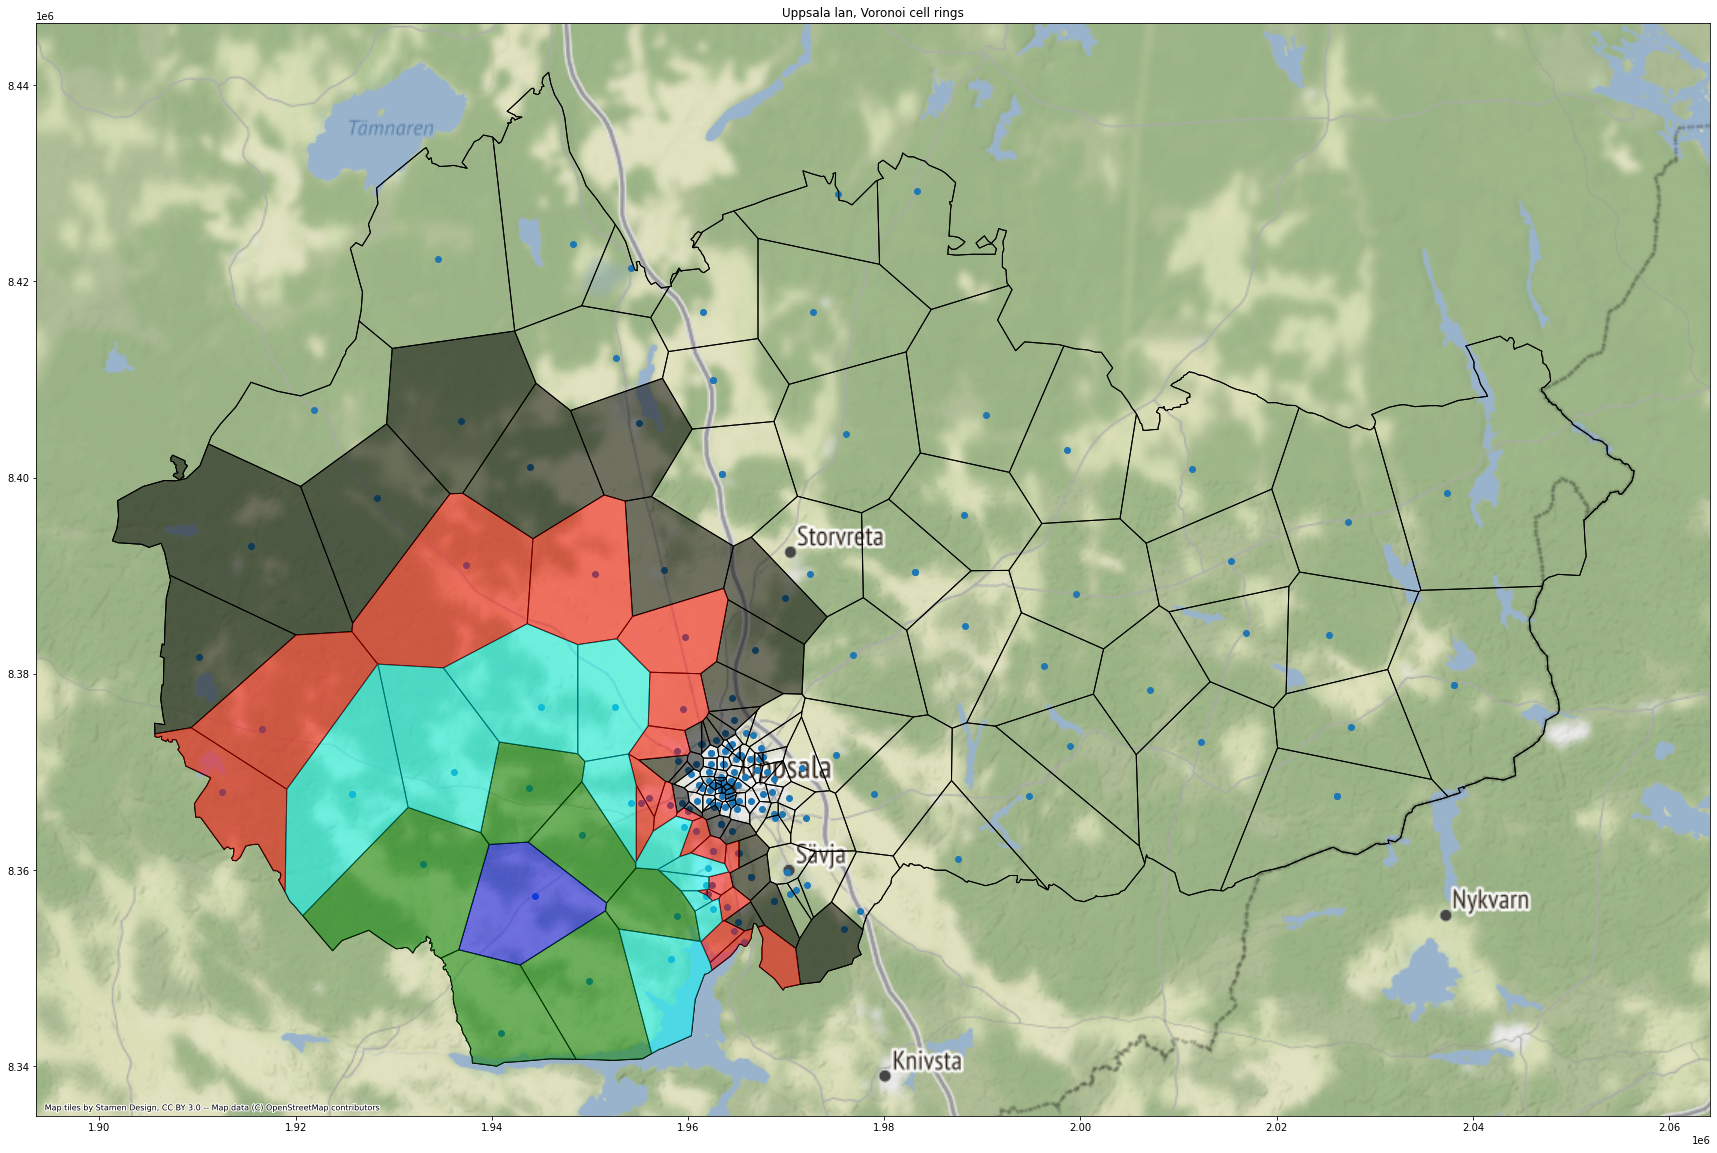

In [77]:
# _make_sample_ring_plot()

In [20]:
!ls

Untitled.ipynb          cli.py                  rings.py
__init__.py             data                    se_shapefiles
__pycache__             hist.png                sverige_contour
alla_kommuner           marina_tracks.ipynb     upp_vor_cell.png
antennas                private_swedish_mind.py


In [21]:
sweden = get_bounding_area()
uppsala_lan = get_bounding_area(point = SWEREF_EPSG_uppsala)

In [22]:
antennas_within, voronoi_polygons = get_vcs_for_bounding_area(antennas_gdp, sweden)

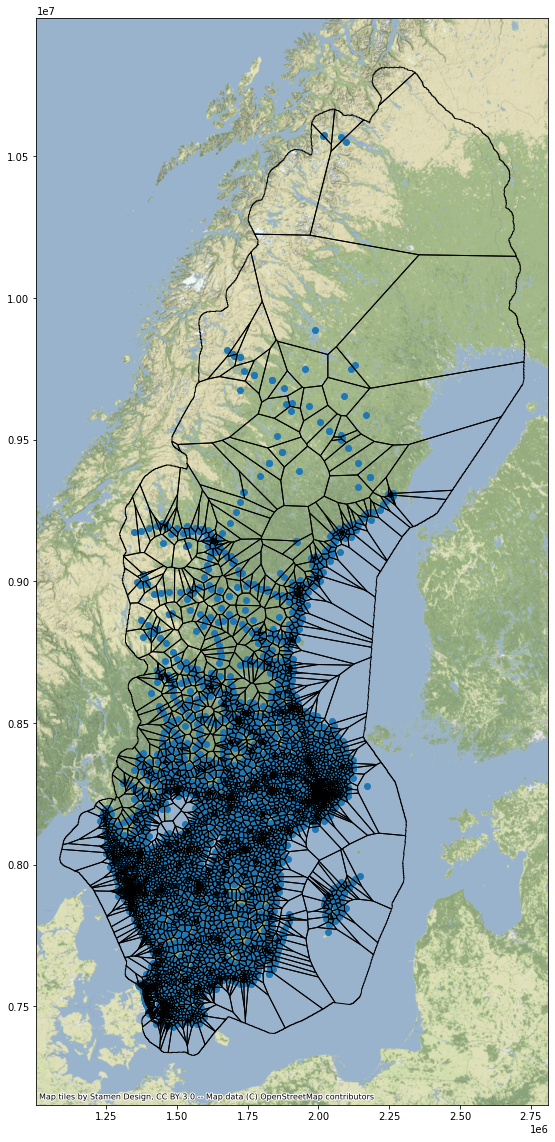

In [23]:
ax = antennas_within.to_crs(WGS84_EPSG).plot(figsize= (20,20))
voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax,  facecolor='none')
ctx.add_basemap(ax=ax, zoom=9)

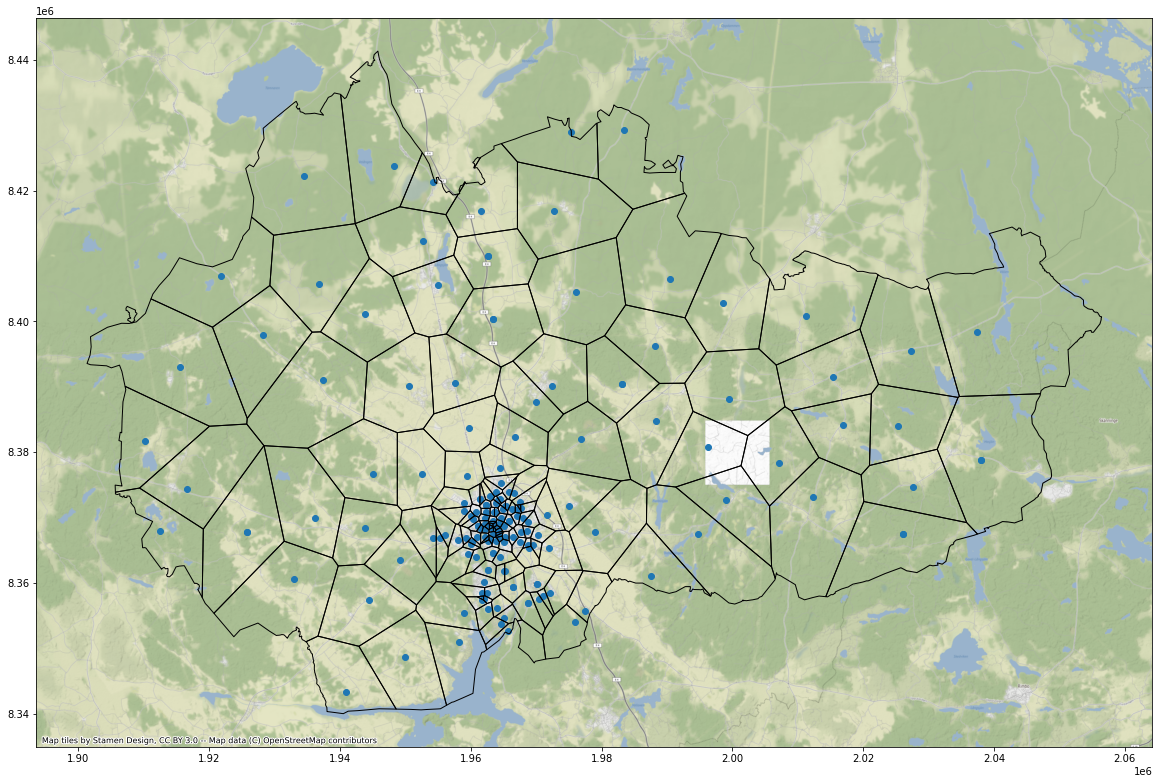

In [26]:
antennas_within, voronoi_polygons = get_vcs_for_bounding_area(antennas_gdp, uppsala_lan)


ax = antennas_within.to_crs(WGS84_EPSG).plot(figsize= (20,20))
voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax,  facecolor='none')
ctx.add_basemap(ax=ax, zoom=12)

# reading the datasets

In [29]:
read_df = read_data(dates)

51 data/result2019-05-23.csv
138 data/result2019-05-26.csv
27 data/result2019-06-12.csv
89 data/result2019-06-22.csv
131 data/result2018-10-26_2018-10-27.csv
246 data/result2018-05-23_2018-05-24.csv
371 data/result2017-11-20_2017-11-21.csv


In [30]:
read_df

timestamp                         geometry_gps_csv  \
0    2019-05-23 13:50:00  [1541218.3500328728, 8117969.018622401]   
1    2019-05-23 14:30:00   [1542727.347574737, 8114445.220161615]   
2    2019-05-23 14:30:00   [1542727.347574737, 8114445.220161615]   
3    2019-05-23 14:40:00  [1554443.1055391137, 8127691.898397599]   
4    2019-05-23 14:40:00  [1554443.1055391137, 8127691.898397599]   
...                  ...                                      ...   
1048 2017-11-21 22:35:00   [2090807.2508528575, 8330158.61294096]   
1049 2017-11-21 22:40:00   [2090802.6760792641, 8330158.61294096]   
1050 2017-11-21 22:45:00   [2090802.6760792641, 8330158.61294096]   
1051 2017-11-21 22:50:00   [2090802.6760792646, 8330158.61294096]   
1052 2017-11-21 22:55:00   [2090802.6760792641, 8330158.61294096]   

                              geometry_mpn_csv  
0       [1546361.310684306, 8122021.062659311]  
1      [1542862.1674228888, 8117797.551964085]  
2      [1541329.6690934196, 8114304.778990858]  
3     [1554932.9121099235, 8127448.6714701615]  
4      [1556157.4260223347, 8117647.521880581]  
...                                        ...  
1048   [2088342.5148085796, 8331062.918022333]  
1049   [2088342.5148085796, 8331062.918022333]  
1050   [2088342.5148085796, 8331062.918022333]  
1051   [2088342.5148085796, 8331062.918022333]  
1052   [2088342.5148085796, 8331062.918022333]  

[1053 rows x 3 columns]

In [31]:
read_df  = process_df(read_df.copy())

In [32]:
read_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 714 entries, 2017-11-20 22:55:00 to 2019-06-22 19:05:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geometry_gps_csv  714 non-null    geometry
 1   geometry_mpn_csv  714 non-null    object  
dtypes: geometry(1), object(1)
memory usage: 16.7+ KB


In [63]:
read_df

index                 geometry_gps_csv  \
0   2017-11-20 22:55:00  POINT (1958889.079 8365752.619)   
1   2017-11-20 23:00:00  POINT (1958889.079 8365752.619)   
2   2017-11-20 23:05:00  POINT (1958889.079 8365752.619)   
3   2017-11-20 23:10:00  POINT (1958889.079 8365752.619)   
4   2017-11-20 23:15:00  POINT (1958889.079 8365752.619)   
..                  ...                              ...   
455 2019-06-12 17:25:00  POINT (1958865.350 8365752.619)   
456 2019-06-12 19:15:00  POINT (1958889.079 8365752.619)   
457 2019-06-12 21:05:00  POINT (1958889.079 8365752.619)   
458 2019-06-12 21:20:00  POINT (1958889.079 8365752.619)   
459 2019-06-12 21:40:00  POINT (1958889.079 8365752.619)   

                                                                                                                            geometry_mpn_csv  
0                                                                                              [POINT (1960770.378799772 8363957.758319987)]  
1                                                                                              [POINT (1960770.378799772 8363957.758319987)]  
2                                                                                              [POINT (1960770.378799772 8363957.758319987)]  
3                                                                                              [POINT (1960770.378799772 8363957.758319987)]  
4                                                                                              [POINT (1960770.378799772 8363957.758319987)]  
..                                                                                                                                       ...  
455                                                                                            [POINT (1960770.378799772 8363957.758319987)]  
456                                                                                            [POINT (1960770.378799772 8363957.758319987)]  
457                                                                                            [POINT (1960770.378799772 8363957.758319987)]  
458                                                                                            [POINT (1964121.095819125 8367969.100367071)]  
459  [POINT (1963920.721140154 8368368.136306725), POINT (1959545.865208583 8364378.735681279), POINT (1960770.378799772 8363957.758319987)]  

[460 rows x 3 columns]

In [34]:
read_df = get_objects_within_area(read_df.copy(), uppsala_lan.to_crs(WGS84_EPSG), geom='geometry_gps_csv')
read_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             460 non-null    datetime64[ns]
 1   geometry_gps_csv  460 non-null    geometry      
 2   geometry_mpn_csv  460 non-null    object        
dtypes: datetime64[ns](1), geometry(1), object(1)
memory usage: 10.9+ KB


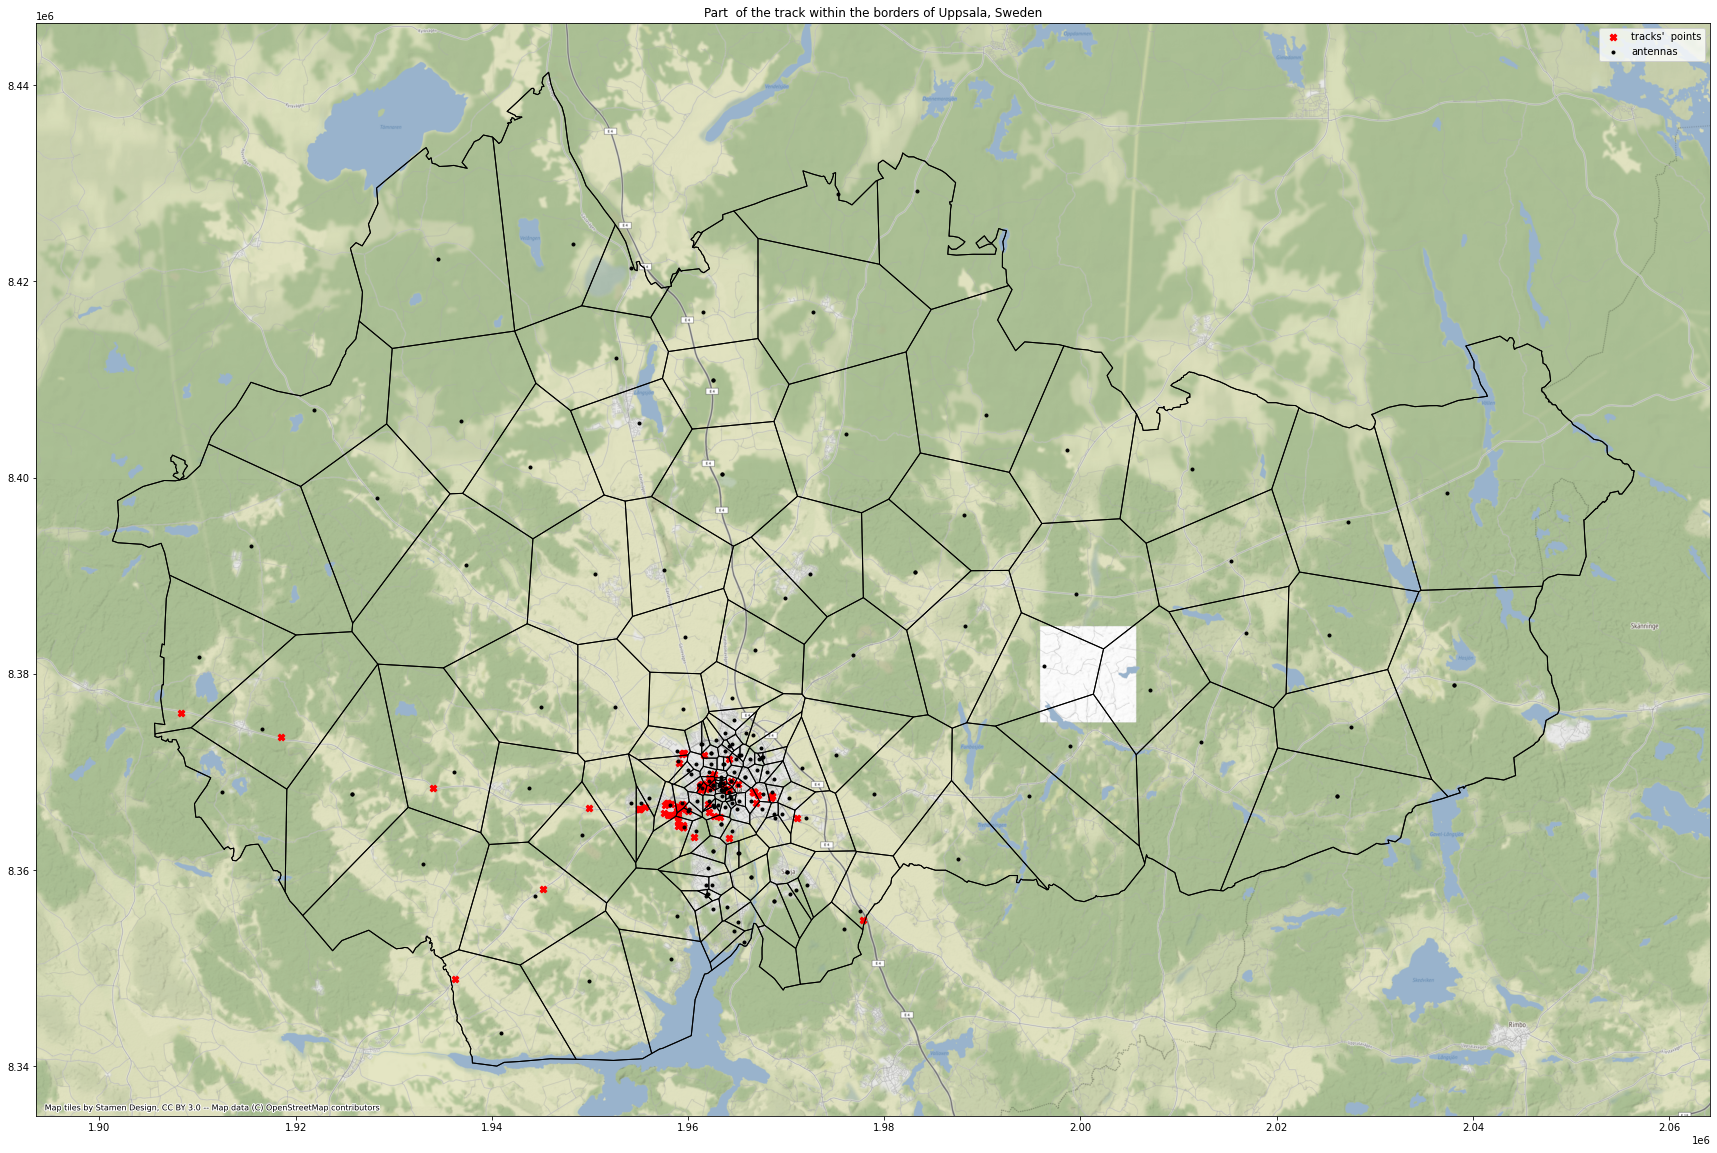

In [62]:
ax = uppsala_lan.to_crs(WGS84_EPSG).plot(figsize= (30,30),  facecolor='none', label = "Uppsala border")
read_df.plot(ax=ax, label= "tracks'  points" , marker='X', markersize=45, color='red')
voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax,  facecolor='none')
antennas_within.to_crs(WGS84_EPSG).plot(ax=ax, label = 'antennas', marker='.', color='black')
ctx.add_basemap(ax=ax, zoom=12)
plt.title('Part  of the track within the borders of Uppsala, Sweden')
plt.legend()
plt.savefig('../docs/pics/track_within_shape.png', bbox_inches = "tight")

In [64]:
read_df = add_vcs_indexes(read_df.copy(), voronoi_polygons.to_crs(WGS84_EPSG))
# read_df

In [65]:
read_df

index                 geometry_gps_csv  \
0   2017-11-20 22:55:00  POINT (1958889.079 8365752.619)   
1   2017-11-20 23:00:00  POINT (1958889.079 8365752.619)   
2   2017-11-20 23:05:00  POINT (1958889.079 8365752.619)   
3   2017-11-20 23:10:00  POINT (1958889.079 8365752.619)   
4   2017-11-20 23:15:00  POINT (1958889.079 8365752.619)   
..                  ...                              ...   
455 2019-06-12 17:25:00  POINT (1958865.350 8365752.619)   
456 2019-06-12 19:15:00  POINT (1958889.079 8365752.619)   
457 2019-06-12 21:05:00  POINT (1958889.079 8365752.619)   
458 2019-06-12 21:20:00  POINT (1958889.079 8365752.619)   
459 2019-06-12 21:40:00  POINT (1958889.079 8365752.619)   

                                                                                                                            geometry_mpn_csv  \
0                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
1                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
2                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
3                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
4                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
..                                                                                                                                       ...   
455                                                                                            [POINT (1960770.378799772 8363957.758319987)]   
456                                                                                            [POINT (1960770.378799772 8363957.758319987)]   
457                                                                                            [POINT (1960770.378799772 8363957.758319987)]   
458                                                                                            [POINT (1964121.095819125 8367969.100367071)]   
459  [POINT (1963920.721140154 8368368.136306725), POINT (1959545.865208583 8364378.735681279), POINT (1960770.378799772 8363957.758319987)]   

     vc_index_gps   vc_index_mpn  
0              82           [80]  
1              82           [80]  
2              82           [80]  
3              82           [80]  
4              82           [80]  
..            ...            ...  
455            82           [80]  
456            82           [80]  
457            82           [80]  
458            82          [125]  
459            82  [126, 83, 80]  

[460 rows x 5 columns]

In [66]:
get_rings_around_cell(119, voronoi_polygons.to_crs(WGS84_EPSG), 2)

[[119],
 [120, 121, 122, 137, 143],
 [81, 90, 94, 96, 129, 130, 136, 139, 141, 142, 145]]

In [67]:
tmp = voronoi_polygons.to_crs(WGS84_EPSG)

%time read_df[ 'vc_gps_rings'] = read_df.apply(lambda row:  get_rings_around_cell(row['vc_index_gps'], tmp, 6), axis=1)

CPU times: user 2min 43s, sys: 3.66 s, total: 2min 47s
Wall time: 2min 50s


In [68]:
mpn = read_df.iloc[4]['vc_index_mpn']
rings = read_df.iloc[4]['vc_gps_rings']
make_hist_mpn_geoms(mpn, rings)

[1]

In [69]:
%time read_df[ 'hist'] = read_df.apply(lambda row:  make_hist_mpn_geoms(row['vc_index_mpn'], row['vc_gps_rings']), axis=1)

CPU times: user 12.1 ms, sys: 579 µs, total: 12.7 ms
Wall time: 12.4 ms


In [83]:
def calculate_distances(point, points):
    """
    caclulates distance between `point` and each of `points`
    """
    
    return point.distance(points)

# read_df.iloc[0].geometry_mpn_csv

In [94]:
[read_df.iloc[0]['geometry_gps_csv'].distance(item) 
 for item in read_df.iloc[0].geometry_mpn_csv]



[2600.156131069833]

In [247]:
%time read_df[ 'distances'] = read_df.apply(lambda row:  [row['geometry_gps_csv'].distance(item)/1000\
                                                          for item in row['geometry_mpn_csv']], axis=1)

CPU times: user 17.9 ms, sys: 3.08 ms, total: 21 ms
Wall time: 18.7 ms


In [248]:
read_df

index                 geometry_gps_csv  \
0   2017-11-20 22:55:00  POINT (1958889.079 8365752.619)   
1   2017-11-20 23:00:00  POINT (1958889.079 8365752.619)   
2   2017-11-20 23:05:00  POINT (1958889.079 8365752.619)   
3   2017-11-20 23:10:00  POINT (1958889.079 8365752.619)   
4   2017-11-20 23:15:00  POINT (1958889.079 8365752.619)   
..                  ...                              ...   
455 2019-06-12 17:25:00  POINT (1958865.350 8365752.619)   
456 2019-06-12 19:15:00  POINT (1958889.079 8365752.619)   
457 2019-06-12 21:05:00  POINT (1958889.079 8365752.619)   
458 2019-06-12 21:20:00  POINT (1958889.079 8365752.619)   
459 2019-06-12 21:40:00  POINT (1958889.079 8365752.619)   

                                                                                                                            geometry_mpn_csv  \
0                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
1                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
2                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
3                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
4                                                                                              [POINT (1960770.378799772 8363957.758319987)]   
..                                                                                                                                       ...   
455                                                                                            [POINT (1960770.378799772 8363957.758319987)]   
456                                                                                            [POINT (1960770.378799772 8363957.758319987)]   
457                                                                                            [POINT (1960770.378799772 8363957.758319987)]   
458                                                                                            [POINT (1964121.095819125 8367969.100367071)]   
459  [POINT (1963920.721140154 8368368.136306725), POINT (1959545.865208583 8364378.735681279), POINT (1960770.378799772 8363957.758319987)]   

     vc_index_gps   vc_index_mpn  \
0              82           [80]   
1              82           [80]   
2              82           [80]   
3              82           [80]   
4              82           [80]   
..            ...            ...   
455            82           [80]   
456            82           [80]   
457            82           [80]   
458            82          [125]   
459            82  [126, 83, 80]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      vc_gps_rings  \
0    [[82], [80, 81, 83, 95, 96], [26, 48, 64, 65, 72, 75, 84, 85, 91, 93, 94, 120, 121, 130], [4, 5, 11, 28, 66, 73, 74, 77, 86, 88, 90, 92, 100, 101, 109, 119, 122, 127, 128, 129, 137], [6, 9, 10, 12, 45, 54, 68, 70, 71, 76, 87, 99, 102, 105, 108, 110, 111, 113, 115, 117, 118, 133, 136, 139, 142, 143, 145, 150], [13, 23, 25, 47, 52, 53, 55, 62, 67, 69, 89, 98, 103, 104, 107, 112, 114, 116, 125, 131, 132, 134, 135, 138, 140, 141, 144, 146, 147, 148, 149, 151, 159, 162, 163], [3, 14, 15, 16, 24, 27, 29, 46, 49, 51, 

In [277]:
def _plot_ring_hist(data, bins=None):
    """
    plotting histogram for rings
    """

    hst = [int(el) for sublist in data.to_list() for el in sublist]
#     print(hst)
    if bins:
        his = np.histogram(hst,bins=bins)
    else:
        his = np.histogram(hst,bins=range(max(hst)+2))
    
    plt.figure(figsize=(15,10))
    plt.xlabel('ring number')
    plt.ylabel('number of occurences')
    plt.title("""Voronoi cell ring histogram for a GPS position
    averaged over 5 minute intervals. Number of GPS positions is %i."""%(read_df.shape[0]))
    plt.bar(his[1][:-1], his[0], width=0.8*(his[1][1]-his[1][0]))


    plt.savefig('../docs/pics/hist_ring.png', bbox_inches = "tight")


In [283]:
def _plot_dist_hist(data, bins=None):
    """
    plotting histogram for rings
    """

    hst = [int(el) for sublist in data.to_list() for el in sublist]
#     print(hst)
    if bins:
        his = np.histogram(hst,bins= bins)
    else:
        his = np.histogram(hst,bins=range(max(hst)+2))
    
    plt.figure(figsize=(15,10))
    plt.xlabel('distance between GPS and MPN points, km')
    plt.ylabel('number of occurences')
    plt.title("""Voronoi cell distance histogram for a GPS position
    averaged over 5 minute intervals. Number of GPS positions is %i."""%(read_df.shape[0]))
    plt.xticks(his[1])


    plt.bar(his[1][:-1], his[0], width=0.8*(his[1][1]-his[1][0]))


    plt.savefig('../docs/pics/hist_dist.png', bbox_inches = "tight")

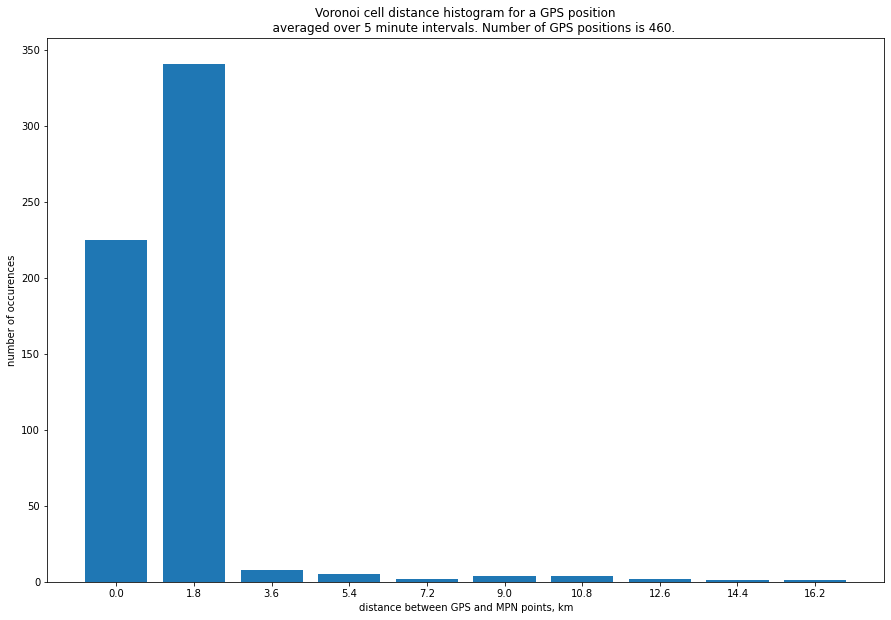

In [284]:
_plot_dist_hist(read_df['distances'], bins=10)

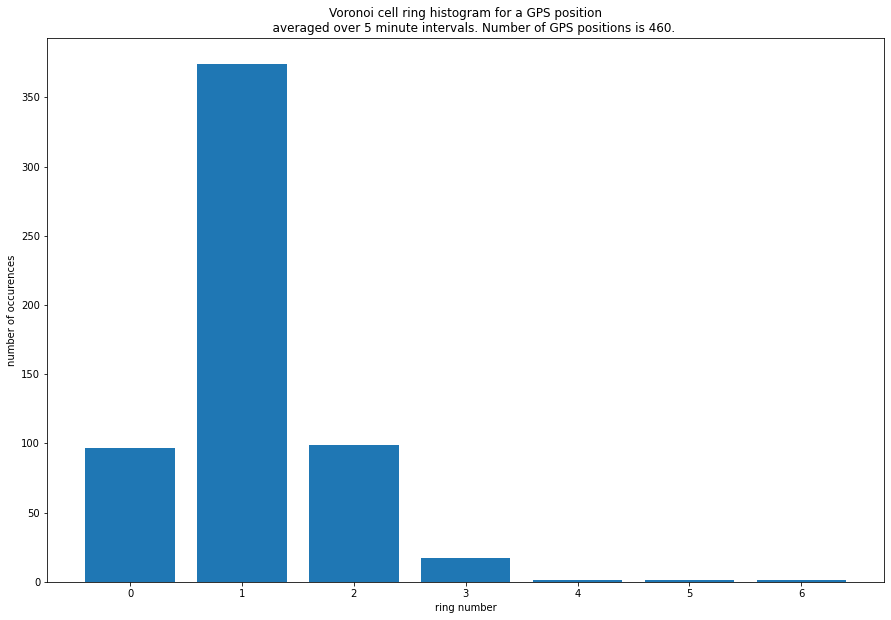

In [280]:
_plot_ring_hist(read_df['hist'])

In [147]:
areas = voronoi_polygons['geometry'].area/10**6

In [39]:
areas

0      105.571455
1       47.692901
2       64.722667
3       22.635160
4       31.188548
          ...    
164      0.416997
165      0.063205
166      2.159153
167      0.746963
168      0.202243
Length: 169, dtype: float64

Text(0, 0.5, 'number of occurencies')

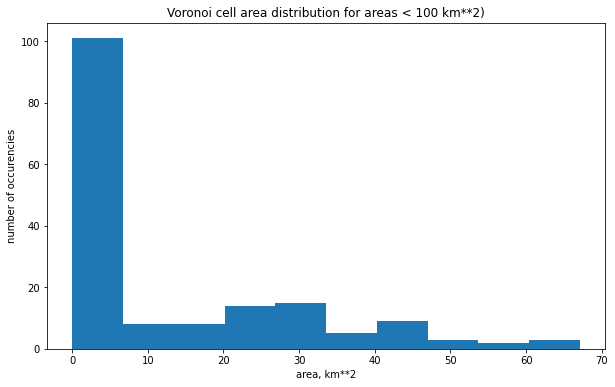

In [40]:
plt.figure(figsize=(10,6))

max_area = 100
plt.hist(areas[areas.values < max_area])
plt.title("Voronoi cell area distribution for areas < %i km**2)"%max_area)
plt.xlabel('area, km**2')
plt.ylabel('number of occurencies')


In [41]:
linear_size_vc_uppsala = np.sqrt(voronoi_polygons['geometry'].area/10**6)


In [42]:
linear_size_vc_uppsala

0      10.274797
1       6.906005
2       8.045040
3       4.757642
4       5.584671
         ...    
164     0.645753
165     0.251405
166     1.469406
167     0.864270
168     0.449714
Length: 169, dtype: float64

In [43]:
linear_size_vc_uppsala.describe()

count    169.000000
mean       2.714345
std        2.441717
min        0.227106
25%        0.646969
50%        1.406574
75%        4.979174
max       10.274797
dtype: float64

Text(0.5, 1.0, 'linear size VC histogram for Uppsala')

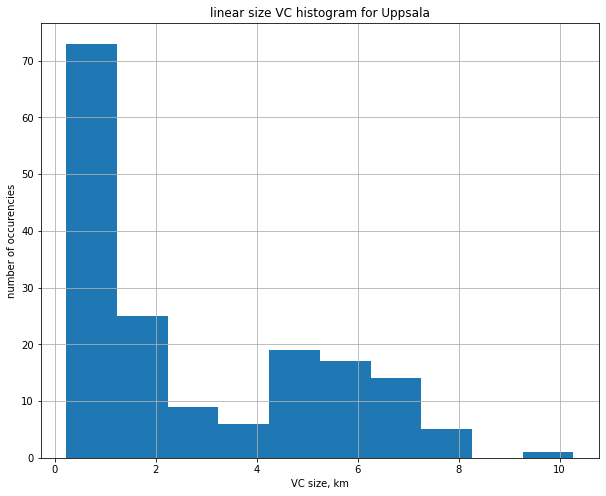

In [44]:
plt.figure(figsize=(10,8))


linear_size_vc_uppsala.hist()
plt.xlabel('VC size, km')
plt.ylabel('number of occurencies')
plt.title('linear size VC histogram for Uppsala')